# Autovalores em ecologia

Uma aplicação interessante da álgebra linear são modelos de população matricial, amplamente utilizados na ecologia e em problemas demográficos. Um tipo de modelo considera a distribuição etária da fertilidade e sobrevivência em uma população animal ou vegetal. Vamos ver como isso ocorre em um estudo de caso sobre coelhos.

In [1]:
# execute essa linha de código para importar as definições do plot_helper

import numpy
from numpy.linalg import inv, eig
from math import ceil
from matplotlib import pyplot, ticker, get_backend, rc
from mpl_toolkits.mplot3d import Axes3D
from itertools import cycle

# interactive backends
_int_backends = ['GTK3Agg', 'GTK3Cairo', 'MacOSX', 'nbAgg',
                 'Qt4Agg', 'Qt4Cairo', 'Qt5Agg', 'Qt5Cairo',
                 'TkAgg', 'TkCairo', 'WebAgg', 'WX', 'WXAgg', 'WXCairo']
_backend = get_backend()   # get current backend name

# shrink figsize and fontsize when using %matplotlib notebook
if _backend in _int_backends:
    fontsize = 4
    fig_scale = 0.75
else:
    fontsize = 5
    fig_scale = 1

grey = '#808080'
gold = '#cab18c'   # x-axis grid
lightblue = '#0096d6'  # y-axis grid
green = '#008367'  # x-axis basis vector
red = '#E31937'    # y-axis basis vector
darkblue = '#004065'

pink, yellow, orange, purple, brown = '#ef7b9d', '#fbd349', '#ffa500', '#a35cff', '#731d1d'

quiver_params = {'angles': 'xy',
                 'scale_units': 'xy',
                 'scale': 1,
                 'width': 0.012}

grid_params = {'linewidth': 0.5,
               'alpha': 0.8}

def set_rc(func):
    def wrapper(*args, **kwargs):
        rc('font', family='serif', size=fontsize)
        rc('figure', dpi=200)
        rc('axes', axisbelow=True, titlesize=5)
        rc('lines', linewidth=1)
        func(*args, **kwargs)
    return wrapper

@set_rc
def plot_vector(vectors, tails=None):
    ''' Draw 2d vectors based on the values of the vectors and the position of their tails.
    
    Parameters
    ----------
    vectors : list.
        List of 2-element array-like structures, each represents a 2d vector.
    
    tails : list, optional.
        List of 2-element array-like structures, each represents the coordinates of the tail
        of the corresponding vector in vectors. If None (default), all tails are set at the
        origin (0,0). If len(tails) is 1, all tails are set at the same position. Otherwise,
        vectors and tails must have the same length.
    
    Examples
    --------
    >>> v = [(1, 3), (3, 3), (4, 6)]
    >>> plot_vector(v)      # draw 3 vectors with their tails at origin
    >>> t = [numpy.array((2, 2))]
    >>> plot_vector(v, t)   # draw 3 vectors with their tails at (2,2)
    >>> t = [[3, 2], [-1, -2], [3, 5]]
    >>> plot_vector(v, t)   # draw 3 vectors with 3 different tails
    '''   
    vectors = numpy.array(vectors)
    assert vectors.shape[1] == 2, "Each vector should have 2 elements."  
    if tails is not None:
        tails = numpy.array(tails)
        assert tails.shape[1] == 2, "Each tail should have 2 elements."
    else:
        tails = numpy.zeros_like(vectors)
    
    # tile vectors or tails array if needed
    nvectors = vectors.shape[0]
    ntails = tails.shape[0]
    if nvectors == 1 and ntails > 1:
        vectors = numpy.tile(vectors, (ntails, 1))
    elif ntails == 1 and nvectors > 1:
        tails = numpy.tile(tails, (nvectors, 1))
    else:
        assert tails.shape == vectors.shape, "vectors and tail must have a same shape"

    # calculate xlimit & ylimit
    heads = tails + vectors
    limit = numpy.max(numpy.abs(numpy.hstack((tails, heads))))
    limit = numpy.ceil(limit * 1.2)   # add some margins
    
    figsize = numpy.array([2,2]) * fig_scale
    figure, axis = pyplot.subplots(figsize=figsize)
    axis.quiver(tails[:,0], tails[:,1], vectors[:,0], vectors[:,1], color=darkblue, 
                  angles='xy', scale_units='xy', scale=1)
    axis.set_xlim([-limit, limit])
    axis.set_ylim([-limit, limit])
    axis.set_aspect('equal')

    # if xticks and yticks of grid do not match, choose the finer one
    xticks = axis.get_xticks()
    yticks = axis.get_yticks()
    dx = xticks[1] - xticks[0]
    dy = yticks[1] - yticks[0]
    base = max(int(min(dx, dy)), 1)   # grid interval is always an integer
    loc = ticker.MultipleLocator(base=base)
    axis.xaxis.set_major_locator(loc)
    axis.yaxis.set_major_locator(loc)
    axis.grid(True, **grid_params)
    
    # show x-y axis in the center, hide frames
    axis.spines['left'].set_position('center')
    axis.spines['bottom'].set_position('center')
    axis.spines['right'].set_color('none')
    axis.spines['top'].set_color('none')

@set_rc
def plot_transformation_helper(axis, matrix, *vectors, unit_vector=True, unit_circle=False, title=None):
    """ A helper function to plot the linear transformation defined by a 2x2 matrix.
    
    Parameters
    ----------
    axis : class matplotlib.axes.Axes.
        The axes to plot on.
    matrix : class numpy.ndarray.
        The 2x2 matrix to visualize.
    *vectors : class numpy.ndarray.
        The vector(s) to plot along with the linear transformation. Each array denotes a vector's
        coordinates before the transformation and must have a shape of (2,). Accept any number of vectors. 
    
    unit_vector : bool, optional.
        Whether to plot unit vectors of the standard basis, default to True.
    
    unit_circle: bool, optional.
        Whether to plot unit circle, default to False.
    
    title: str, optional.
        Title of the plot.
    """
    assert matrix.shape == (2,2), "the input matrix must have a shape of (2,2)"
    grid_range = 20
    x = numpy.arange(-grid_range, grid_range+1)
    X_, Y_ = numpy.meshgrid(x,x)
    I = matrix[:,0]
    J = matrix[:,1]
    X = I[0]*X_ + J[0]*Y_
    Y = I[1]*X_ + J[1]*Y_
    origin = numpy.zeros(1)
        
    # draw grid lines
    for i in range(x.size):
        axis.plot(X[i,:], Y[i,:], c=gold, **grid_params)
        axis.plot(X[:,i], Y[:,i], c=lightblue, **grid_params)
    
    # draw (transformed) unit vectors
    if unit_vector:
        axis.quiver(origin, origin, [I[0]], [I[1]], color=green, **quiver_params)
        axis.quiver(origin, origin, [J[0]], [J[1]], color=red, **quiver_params)

    # draw optional vectors
    color_cycle = cycle([pink, darkblue, orange, purple, brown])
    if vectors:
        for vector in vectors:
            color = next(color_cycle)
            vector_ = matrix @ vector.reshape(-1,1)
            axis.quiver(origin, origin, [vector_[0]], [vector_[1]], color=color, **quiver_params)

    # draw optional unit circle
    if unit_circle:
        alpha =  numpy.linspace(0, 2*numpy.pi, 41)
        circle = numpy.vstack((numpy.cos(alpha), numpy.sin(alpha)))
        circle_trans = matrix @ circle
        axis.plot(circle_trans[0], circle_trans[1], color=red, lw=0.8)

    # hide frames, set xlimit & ylimit, set title
    limit = 4
    axis.spines['left'].set_position('center')
    axis.spines['bottom'].set_position('center')
    axis.spines['left'].set_linewidth(0.3)
    axis.spines['bottom'].set_linewidth(0.3)
    axis.spines['right'].set_color('none')
    axis.spines['top'].set_color('none')
    axis.set_xlim([-limit, limit])
    axis.set_ylim([-limit, limit])
    if title is not None:
        axis.set_title(title)

@set_rc
def plot_linear_transformation(matrix, *vectors, unit_vector=True, unit_circle=False):
    """ Plot the linear transformation defined by a 2x2 matrix using the helper
    function plot_transformation_helper(). It will create 2 subplots to visualize some
    vectors before and after the transformation.
    
    Parameters
    ----------
    matrix : class numpy.ndarray.
        The 2x2 matrix to visualize.
    *vectors : class numpy.ndarray.
        The vector(s) to plot along with the linear transformation. Each array denotes a vector's
        coordinates before the transformation and must have a shape of (2,). Accept any number of vectors.
    
    unit_vector : bool, optional.
        Whether to plot unit vectors of the standard basis, default to True.
    
    unit_circle: bool, optional.
        Whether to plot unit circle, default to False.
    
    """
    figsize = numpy.array([4,2]) * fig_scale
    figure, (axis1, axis2) = pyplot.subplots(1, 2, figsize=figsize)
    plot_transformation_helper(axis1, numpy.identity(2), *vectors, unit_vector=unit_vector, unit_circle=unit_circle, title='Before transformation')
    plot_transformation_helper(axis2, matrix, *vectors, unit_vector=unit_vector, unit_circle=unit_circle, title='After transformation')

@set_rc
def plot_linear_transformations(*matrices, unit_vector=True, unit_circle=False):
    """ Plot the linear transformation defined by a sequence of n 2x2 matrices using the helper
    function plot_transformation_helper(). It will create n+1 subplots to visualize some
    vectors before and after each transformation.
    Parameters
    ----------
    *matrices : class numpy.ndarray.
        The 2x2 matrices to visualize. Accept any number of matrices.
    
    unit_vector : bool, optional.
        Whether to plot unit vectors of the standard basis, default to True.
    
    unit_circle: bool, optional.
        Whether to plot unit circle, default to False.
      
    """
    nplots = len(matrices) + 1
    nx = 2
    ny = ceil(nplots/nx)
    figsize = numpy.array([2*nx, 2*ny]) * fig_scale
    figure, axes = pyplot.subplots(nx, ny, figsize=figsize)

    for i in range(nplots):  # fig_idx 
        if i == 0:
            matrix_trans = numpy.identity(2)
            title = 'Antes da Transformação'
        else:
            matrix_trans = matrices[i-1] @ matrix_trans
            if i == 1:
                title = 'Depois de {} Trasnformação'.format(i)
            else:
                title = 'Depois de {} Transformações'.format(i)
        plot_transformation_helper(axes[i//nx, i%nx], matrix_trans, unit_vector=unit_vector, unit_circle=unit_circle, title=title)
    # hide axes of the extra subplot (only when nplots is an odd number)
    if nx*ny > nplots:
        axes[-1,-1].axis('off')
        
@set_rc
def plot_3d_transformation_helper(axis, matrix, grid=True, unit_sphere=False, title=None):
    """ A helper function to plot the linear transformation defined by a 3x3 matrix.
    
    Parameters
    ----------
    axis : class matplotlib.axes.Axes.
        The axes to plot on.
    matrix : class numpy.ndarray.
        The 3x3 matrix to visualize.
    grid : bool, optional.
        Whether to plot 3d grid lines, default to True.
    
    unit_sphere : bool, optional.
        Whether to plot unit sphere, default to False.
    
    title : str, optional.
        Title of the plot.
    """
    assert matrix.shape == (3,3), "the input matrix must have a shape of (3,3)"
    xcolor, ycolor, zcolor = '#0084b6', '#d8a322', '#FF3333'
    linewidth = 0.7
    if grid:
        grid_range = 2
        x = numpy.arange(-grid_range, grid_range+1)
        X, Y, Z = numpy.meshgrid(x,x,x)
        X_new = matrix[0,0]*X + matrix[0,1]*Y + matrix[0,2]*Z
        Y_new = matrix[1,0]*X + matrix[1,1]*Y + matrix[1,2]*Z
        Z_new = matrix[2,0]*X + matrix[2,1]*Y + matrix[2,2]*Z
        for i in range(x.size):
            for j in range(x.size):
                axis.plot(X_new[:,i,j], Y_new[:,i,j], Z_new[:,i,j], color=xcolor, linewidth=linewidth)
                axis.plot(X_new[i,:,j], Y_new[i,:,j], Z_new[i,:,j], color=ycolor, linewidth=linewidth)
                axis.plot(X_new[i,j,:], Y_new[i,j,:], Z_new[i,j,:], color=zcolor, linewidth=linewidth)
    
    if unit_sphere:
        u = numpy.linspace(0, 2 * numpy.pi, 100)
        v = numpy.linspace(0, numpy.pi, 100)
        X = 1 * numpy.outer(numpy.cos(u), numpy.sin(v))
        Y = 1 * numpy.outer(numpy.sin(u), numpy.sin(v))
        Z = 1 * numpy.outer(numpy.ones(numpy.size(u)), numpy.cos(v))
        X_new = matrix[0,0]*X + matrix[0,1]*Y + matrix[0,2]*Z
        Y_new = matrix[1,0]*X + matrix[1,1]*Y + matrix[1,2]*Z
        Z_new = matrix[2,0]*X + matrix[2,1]*Y + matrix[2,2]*Z
        axis.plot_surface(X_new, Y_new, Z_new, rstride=4, cstride=4, linewidth=0, cmap='ocean', alpha=0.6)

    if title is not None:
        axis.set_title(title)
    
    limit = 0
    if grid or unit_sphere:
        for array in (X_new, Y_new, Z_new):
            limit_ = numpy.max(numpy.abs(array))
            limit = max(limit, limit_)
    else:
        limit = 1
    axis.set_xlim(-limit, limit)
    axis.set_ylim(-limit, limit)
    axis.set_zlim(-limit, limit)
    # adjust the whitespace between ticks and axes to get a tighter plot
    for axis_str in ['x', 'y', 'z']:
        axis.tick_params(axis=axis_str, pad=-3)

@set_rc
def plot_3d_linear_transformation(matrix, grid=True, unit_sphere=False):
    """ Plot the linear transformation defined by a 3x3 matrix using the helper
    function plot_3d_transformation_helper(). It will create 2 subplots to visualize some
    vectors before and after the transformation.
    
    Parameters
    ----------
    matrix : class numpy.ndarray.
        The 3x3 matrix to visualize.
    grid : bool, optional.
        Whether to plot 3d grid lines, default to True.
    
    unit_sphere : bool, optional.
        Whether to plot unit sphere, default to False.
    """
    
    figsize = numpy.array([4,2]) * fig_scale
    figure = pyplot.figure(figsize=figsize)
    axis1 = figure.add_subplot(1, 2, 1, projection='3d')
    axis2 = figure.add_subplot(1, 2, 2, projection='3d')
    plot_3d_transformation_helper(axis1, numpy.identity(3), grid=grid, unit_sphere=unit_sphere, title='before transformation')
    plot_3d_transformation_helper(axis2, matrix, grid=grid, unit_sphere=unit_sphere, title='after transformation')

@set_rc
def plot_3d_linear_transformations(*matrices, grid=False, unit_sphere=False):
    """ Plot the linear transformation defined by a sequence of n 3x3 matrices using the helper
    function plot_3d_transformation_helper(). It will create n+1 subplots to visualize some
    vectors before and after each transformation.
    
    Parameters
    ----------
    *matrices : class numpy.ndarray.
        The 3x3 matrices to visualize. Accept any number of matrices. 
    grid : bool, optional.
        Whether to plot 3d grid lines, default to False.
    
    unit_sphere : bool, optional.
        Whether to plot unit sphere, default to False.
    """
    nplots = len(matrices) + 1
    nx = 2                 # number of figures per row
    ny = ceil(nplots/nx)   # number of figures per column
    figsize = numpy.array([2*nx, 2*ny]) * fig_scale
    figure = pyplot.figure(figsize=figsize)

    for i in range(nplots):  # fig_idx
        axis = figure.add_subplot(ny, nx, i+1, projection='3d')
        if i == 0:
            matrix_trans = numpy.identity(3)
            title = 'Antes da Transformação'
        else:
            matrix_trans = matrices[i-1] @ matrix_trans
            if i == 1:
                title = 'Depois de {} Transformação'.format(i)
            else:
                title = 'Depois de {} Transformações'.format(i)
        plot_3d_transformation_helper(axis, matrix_trans, grid=grid, unit_sphere=unit_sphere, title=title)

@set_rc
def plot_basis_helper(axis, I, J, *vectors, title=None, I_label='i', J_label='j'):
    """ A helper function to plot the 2D coordinate system determined by the basis I,J.
    
    Parameters
    ----------
    axis : class matplotlib.axes.Axes.
        The axes to plot on.
    I, J: class numpy.ndarray.
        The coordinates of the basis vector in the standard basis.
    *vectors : class numpy.ndarray.
        The vector(s) to plot along with the change of basis. Each array denotes a vector's
        coordinates in I-J coordinate system (not in the standard basis). Each vector must have
        a shape of (2,). Accept any number of vectors.
    
    I_label, J_label : str, optional.
        Label of the new basis, default to 'i' and 'j'.
    
    title: str, optional.
        Title of the plot.
    """
    grid_range = 20
    x = numpy.arange(-grid_range, grid_range+1)
    X_, Y_ = numpy.meshgrid(x,x)   # grid coordinates on the new basis
    X = I[0]*X_ + J[0]*Y_   # grid coordinates on the standard basis
    Y = I[1]*X_ + J[1]*Y_
    
    # draw origin
    origin = numpy.zeros(1)
    axis.scatter(origin, origin, c='black', s=3)

    # draw grid lines of the new coordinate system
    lw_grid = 0.4
    for i in range(x.size):
        axis.plot(X[i,:], Y[i,:], c=grey, lw=lw_grid)
        axis.plot(X[:,i], Y[:,i], c=grey, lw=lw_grid)
    
    # highlight new axes (spines)
    lw_spine = 0.7
    zero_id = numpy.where(x==0)[0][0]
    axis.plot(X[zero_id,:], Y[zero_id,:], c=gold, lw=lw_spine)
    axis.plot(X[:,zero_id], Y[:,zero_id], c=lightblue, lw=lw_spine)

    # draw basis vectors using quiver plot
    axis.quiver(origin, origin, [I[0]], [I[1]], color=gold, **quiver_params)
    axis.quiver(origin, origin, [J[0]], [J[1]], color=lightblue, **quiver_params)

    # draw input vector on new coordinate system
    bound = 5
    if vectors:
        for vector in vectors:
            M = numpy.transpose(numpy.vstack((I,J)))
            vector = M @ vector.reshape(-1,1)
            axis.quiver(origin, origin, [vector[0]], [vector[1]], color=red, **quiver_params)
            bound = max(ceil(numpy.max(numpy.abs(vector))), bound)
    
    # hide frames, set xlimit & ylimit, set title
    axis.set_xlim([-bound, bound])
    axis.set_ylim([-bound, bound])
    axis.axis('off')
    if title is not None:
        axis.set_title(title)

    # add text next to new basis vectors
    text_params = {'ha': 'center', 'va': 'center', 'size' : 6}
    axis.text((I[0]-J[0])/2*1.1, (I[1]-J[1])/2*1.1, r'${}$'.format(I_label), color=gold, **text_params)
    axis.text((J[0]-I[0])/2*1.1, (J[1]-I[1])/2*1.1, r'${}$'.format(J_label), color=lightblue, **text_params)

@set_rc
def plot_basis(I, J, *vectors):
    """ Plot 2d vectors on the coordinates system defined by basis I and J using the helper funtion
    plot_basis_helper().
    
    Parameters
    ----------
    I, J: class numpy.ndarray.
        The coordinates of the basis vector in the standard basis.
    *vectors : class numpy.ndarray.
        The vector(s) to plot along with the change of basis. Each array denotes a vector's
        coordinates in I-J coordinate system (not in the standard basis). Each vector must have
        a shape of (2,). Accept any number of vectors.
    """
    figsize = numpy.array([2,2]) * fig_scale
    figure, axis = pyplot.subplots(figsize=figsize)
    plot_basis_helper(axis, I, J, *vectors)

@set_rc
def plot_change_basis(I, J, *vectors):
    """ Create a side-by-side plot of some vectors both on the standard basis and on the new basis
    defined by I and J, using the helper function plot_basis_helper().
    
    Parameters
    ----------
    I, J: class numpy.ndarray.
        The coordinates of the basis vector in the standard basis.
    *vectors : class numpy.ndarray.
        The vector(s) to plot along with the change of basis. Each array denotes a vector's
        coordinates in I-J coordinate system (not in the standard basis). Each vector must have
        a shape of (2,). Accept any number of vectors.
    """
    figsize = numpy.array([4,2]) * fig_scale
    figure, (axis1, axis2) = pyplot.subplots(1, 2, figsize=figsize)
    M = numpy.transpose(numpy.vstack((I,J)))
    M_inv = inv(M)
    vectors_ = [ M_inv @ vector.reshape(-1, 1) for vector in vectors ]
    plot_basis_helper(axis1, numpy.array([1,0]), numpy.array([0,1]), *vectors, title='standard basis')
    plot_basis_helper(axis2, I, J, *vectors_, title='new basis', I_label='a', J_label='b')

@set_rc
def plot_eigen(matrix):
    """ Visualize the eigendecomposition of a 2x2 matrix as a combination of changing basis 
    and scaling transformation, using the helper function plot_basis_helper().
    Parameters
    ----------
    matrix : class numpy.ndarray.
        The 2x2 matrix to visualize.
    """
    figsize = numpy.array([4,4]) * fig_scale
    figure, axes = pyplot.subplots(2, 2, figsize=figsize)
    
    eigenvalues, eigenvectors = eig(matrix)
    C = eigenvectors
    D = numpy.diag(eigenvalues)
    C_inv = inv(C)

    alpha =  numpy.linspace(0, 2*numpy.pi, 41)
    circle = numpy.vstack((numpy.cos(alpha), numpy.sin(alpha)))

    plot_basis_helper(axes[0,0], numpy.array([1,0]), numpy.array([0,1]), title=r'coords in standard basis $\mathbf{x}$')
    plot_basis_helper(axes[0,1], C[:,0], C[:,1], title=r'change to new basis $C^{-1}\mathbf{x}$', I_label='a', J_label='b')
    plot_basis_helper(axes[1,0], C[:,0], C[:,1], title=r'scale along new basis $DC^{-1}\mathbf{x}$', I_label='a', J_label='b')
    plot_basis_helper(axes[1,1], numpy.array([1,0]), numpy.array([0,1]), title=r'change back to standard basis $CDC^{-1}\mathbf{x}$')

    circle_trans = matrix @ circle
    for axis in axes[0]:
        axis.plot(circle[0], circle[1], color=red, lw=0.8)
    for axis in axes[1]:
        axis.plot(circle_trans[0], circle_trans[1], color=red, lw=0.8)

if __name__ == "__main__":
    pass

# funções definidas por L Barba e T Wang para uma apresentação no evento SciPy 2019 
# aplicação das funções para a aula do professor Edmar Candeia Gurjão feitas por Alysson Machado

In [2]:
import numpy # importando a biblioteca de funções do Python numpy
%matplotlib inline
from matplotlib import pyplot # importando a biblioteca de funções do Python matplotlib

In [3]:
import sys # importa as definições feitas no plot_helper
sys.path.append('../scripts/')

# Ao importar, teremos acesso as funções: 
# plot_vector, plot_linear_transformation, plot_linear_transformations

Em uma população de coelhos:

1-)metade dos coelhos recém-nascidos sobrevivem no primeiro ano de vida; 


2-)metade dos coelhos sobrevivem no segundo ano de vida; 

3-)os coelhos vivem no máximo até três anos; 

4-)coelhos produzem 0, 6, 8 outros coelhos no primeiro, segundo e terceiro anos, respectivamente.

Sejam Xt, Yt e Zt a quantidade de coelhos no período de 0, 1 e 2 anos de idade, respectivamente, em um certo período t de tempo após o início do estudo, podemos definir:

$$X_{t+1} = 0X_{t} + 6Y_{t} + 8Z_{t}$$

$$X_{t+1} = 1/2X_{t} + 0Y_{t} + 0Z_{t}$$

$$X_{t+1} = 0X_{t} + 1/2Y_{t} + 0Z_{t}$$

As coordenadas do sistema podem ser definidos em uma matriz L:


$$L = \begin{bmatrix}
          0 & 6 & 8 \\
          0.5 & 0 & 0 \\
          0 & 0.5 & 0 \\
          \end{bmatrix}$$

In [4]:
L = numpy.array([[0,6,8], [0.5,0,0], [0,0.5,0]]) # definindo a matriz L

In [5]:
#imprimindo a matriz
print("{}".format(L))

[[0.  6.  8. ]
 [0.5 0.  0. ]
 [0.  0.5 0. ]]


Essa matriz representa a transição etária ano após ano. Multiplique essa matriz pelo vetor população para obter a população estruturada por idade no próximo ano. Vamos escrever um pouco de código em Python para ver a população em cada faixa etária crescer mais, ano após ano (conceitos usados exigem conhecimentos em Cadeias de Markov, em que um sistema muda para outro).

Seja p a população inicial de coelhos, podemos especular: 

1-) 25 coelhos na idade 0; 

2-) 10 coelhos na idade 1; 

3-) 5 coelhos na idade 2; 

In [6]:
p = numpy.array([25, 10, 5]) # definindo um array p, p = população inicial de coelhos

In [7]:
# imprime a população inicial de coelhos
print("{}".format(p))

[25 10  5]


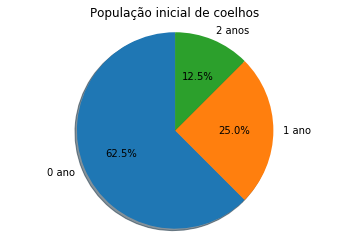

In [8]:
# criando as etiquetas para o gráfico
labels = '0 ano', '1 ano', '2 anos'

# criando a área de plotagem
fig1, ax1 = pyplot.subplots()

# criando o gráfico
ax1.pie(p, labels = labels, autopct = '%1.1f%%', shadow = True, startangle = 90)

# com essa opção, o gráfico ficará em círculo
ax1.axis('equal')

# título do gráfico
pyplot.title("População inicial de coelhos")

# mostra o gráfico
pyplot.show()

O nosso sistema agora vai sofrer uma mudança de estado. Vamos verificar essa mudança de estado após ter se passado 1 ano, provavelmente a população vai ter uma nova modelagem, baseado nas características de vida dos coelhos e na população que tinha no ano anterior.

In [9]:
# multiplica a matriz L com a matriz p
mudanca_estado = numpy.dot(L,p)

In [10]:
# imprime a população de coelhos após 1 ano
print("{}".format(mudanca_estado))

[100.   12.5   5. ]


In [11]:
# imprime a mudança de estado daqui a 1 ano, ou seja, a nova população de coelhos
print("{}".format(mudanca_estado))

[100.   12.5   5. ]


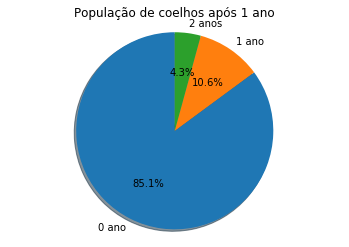

In [12]:
# criando um conjunto de dados
labels = '0 ano', '1 ano', '2 anos'

# criando a área de plotagem
fig1, ax1 = pyplot.subplots()

# criando o gráfico
ax1.pie(mudanca_estado, labels = labels, autopct = '%1.1f%%', shadow = True, startangle = 90)

# com essa opção, o gráfico ficará em círculo
ax1.axis('equal')

# título do gráfico
pyplot.title("População de coelhos após 1 ano")

# mostra o gráfico
pyplot.show()

Qual será o comportamento da população daqui a 10 anos? Bom, para esse fim, vamos fazer a mesma ideia de multiplicação entre matrizes, mas a cada ano posterior, devemos considerar a matriz população do ano anterior, de forma recursiva.

In [13]:
# realiza 10 multiplicações sucessivas considerando o vetor população anterior em cada estado
# estrutura for que varia de 0 a 9
for indice in range (0,10):
    p = numpy.dot(L,p) # define a nova matriz população recursivamente

In [14]:
# imprime a mudança de estado daqui a 10 ano, ou seja, a nova população de coelhos
print("{}".format(p))

[38555.    9730.    2391.25]


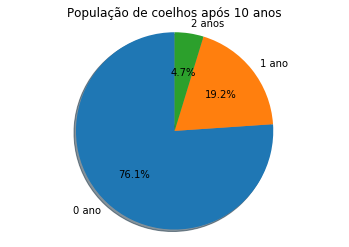

In [15]:
# criando um conjunto de dados
labels = '0 ano', '1 ano', '2 anos'

# criando a área de plotagem
fig1, ax1 = pyplot.subplots()

# criando o gráfico
ax1.pie(p, labels = labels, autopct = '%1.1f%%', shadow = True, startangle = 90)

# com essa opção, o gráfico ficará em círculo
ax1.axis('equal')

# título do gráfico
pyplot.title("População de coelhos após 10 anos")

# mostra o gráfico
pyplot.show()

Daqui a 100 anos, teremos uma outra população de coelhos:


In [16]:
# realiza 100 multiplicações sucessivas considerando o vetor população anterior
# estrutura for que varia de 0 a 99
for indice in range (0,100):
    p = numpy.dot(L,p) # define a nova matriz população recursivamente

In [17]:
# imprime a mudança de estado daqui a 100 ano, ou seja, a nova população de coelhos
print("{}".format(p))

[4.90383592e+34 1.22595898e+34 3.06489745e+33]


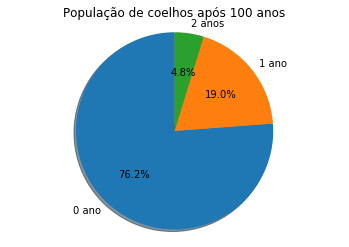

In [18]:
# criando um conjunto de dados
labels = '0 ano', '1 ano', '2 anos'

# criando a área de plotagem
fig1, ax1 = pyplot.subplots()

# criando o gráfico
ax1.pie(p, labels = labels, autopct = '%1.1f%%', shadow = True, startangle = 90)

# com essa opção, o gráfico ficará em círculo
ax1.axis('equal')

# título do gráfico
pyplot.title("População de coelhos após 100 anos")

# mostra o gráfico
pyplot.show()

Após um certo período de tempo, em particular quando o mesmo tende ao infinito, é fácil perceber que os vetores-estado que indicam a razão ou porcentagem de indivíduos para cada idade de coelhos em um certo tempo, convergem a um vetor fixo à medida que o número de observações cresce, e isso é bem definido na teoria de Cadeias de Markov.

Agora vamos pegar os autovalores e autovetores do matriz L e observar algo importante.

In [19]:
(autovalores,autovetores) = numpy.linalg.eig(L) #determinando autovalores e autovetores

In [20]:
# imprimindo os autovalores
print("{}".format(autovalores))

[ 2.         -0.99999998 -1.00000002]


In [21]:
# imprimindo os autovetores
print("{}".format(autovetores))

[[-0.96836405  0.87287156 -0.87287156]
 [-0.24209101 -0.43643579  0.43643578]
 [-0.06052275  0.2182179  -0.21821788]]


Vamos analisar o autovetor relacionado ao autovalor 2:

In [22]:
# deletando o autovetor associado ao -1, que não nos importa
autovetores = numpy.delete(autovetores,1,axis=1)
autovetores = numpy.delete(autovetores,1,axis=1)

In [23]:
# multiplicando por um escalar para melhor visualização
-16.52271 * autovetores

array([[15.99999841],
       [ 3.9999996 ],
       [ 0.9999999 ]])

Isso indica que a cada ano a população dobrará (autovalor = 2) obedecendo a razão 16:4:1 para 0 ano, 1 ano e 2 anos de idade dos coelhos, respectivamente (autovetor associado ao autovalor 2).

Agora, vamos observar melhor um outro estilo de gráfico que mostra a relação ao longo dos anos.

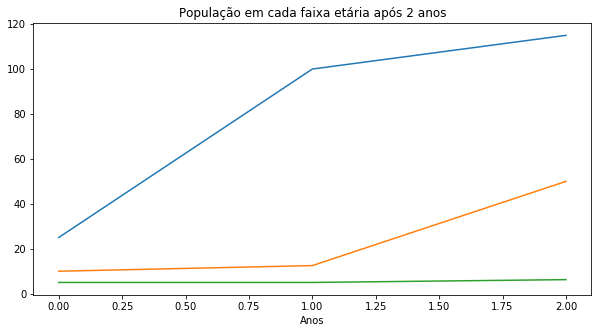

In [24]:
L = numpy.array([[0,6,8], [0.5,0,0], [0,0.5,0]]) # definindo a matriz L

p = numpy.array([25, 10, 5]) # quantidade inicial de indivíduos com 0, 1 e 2 anos de idade, respectivamente

N = 3 # tempo de anos decorridos (nesse caso serão 2 ANOS decorridos, subtraia 1 do números de anos)

# inicializa uma matriz de zeros com as linhas indicando os anos decorridos e colunas a população etária de coelhos
pn = numpy.zeros((N, len(p)))
# adiciona a população inicial a matriz
pn[0,:] = p.copy()

# estrutura de repetição, que inicia um ano após a população inicial até o ano final especificado
for i in range(1,N):
    # adiciona a cada linha subsequente a mudança de estado da população par cada faixa etária dos coelhos, entre as colunas
    pn[i,:] = L.dot(pn[i-1,:])  

# define a dimensão do gráfico
pyplot.figure(figsize=(10,5))
# plota o gráfico da primeira coluna, responsável pelo avanço da população de coelhos com 0 anos de idade
pyplot.plot(pn[:,0],)
# plota o gráfico da segunda coluna, responsável pelo avanço da população de coelhos com 1 anos de idade
pyplot.plot(pn[:,1],)
# plota o gráfico da terceira coluna, responsável pelo avanço da população de coelhos com 2 anos de idade
pyplot.plot(pn[:,2],)
# título do eixo x
pyplot.xlabel('Anos')
# título do gráfico
pyplot.title('População em cada faixa etária após 2 anos');

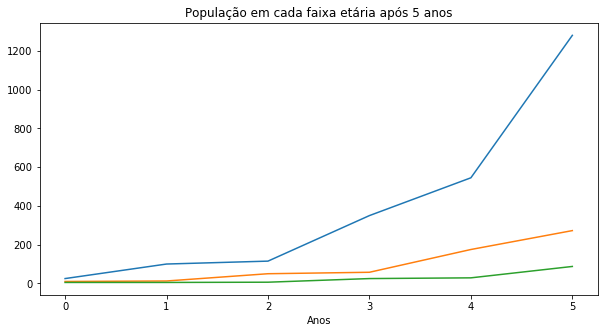

In [25]:
L = numpy.array([[0,6,8], [0.5,0,0], [0,0.5,0]]) # definindo a matriz L

p = numpy.array([25, 10, 5]) # quantidade inicial de indivíduos com 0, 1 e 2 anos de idade, respectivamente

N = 6 # tempo de anos decorridos (nesse caso serão 5 ANOS decorridos, subtraia 1 do números de anos)

# inicializa uma matriz de zeros com as linhas indicando os anos decorridos e colunas a população etária de coelhos
pn = numpy.zeros((N, len(p)))
# adiciona a população inicial a matriz
pn[0,:] = p.copy()

# estrutura de repetição, que inicia um ano após a população inicial até o ano final especificado
for i in range(1,N):
    # adiciona a cada linha subsequente a mudança de estado da população par cada faixa etária dos coelhos, entre as colunas
    pn[i,:] = L.dot(pn[i-1,:])  

# define a dimensão do gráfico
pyplot.figure(figsize=(10,5))
# plota o gráfico da primeira coluna, responsável pelo avanço da população de coelhos com 0 anos de idade
pyplot.plot(pn[:,0],)
# plota o gráfico da segunda coluna, responsável pelo avanço da população de coelhos com 1 anos de idade
pyplot.plot(pn[:,1],)
# plota o gráfico da terceira coluna, responsável pelo avanço da população de coelhos com 2 anos de idade
pyplot.plot(pn[:,2],)
# título do eixo x
pyplot.xlabel('Anos')
# título do gráfico
pyplot.title('População em cada faixa etária após 5 anos');

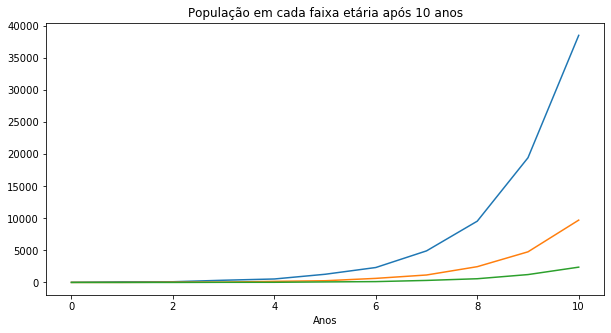

In [26]:
L = numpy.array([[0,6,8], [0.5,0,0], [0,0.5,0]]) # definindo a matriz L

p = numpy.array([25, 10, 5]) # quantidade inicial de indivíduos com 0, 1 e 2 anos de idade, respectivamente

N = 11 # tempo de anos decorridos (nesse caso serão 10 ANOS decorridos, subtraia 1 do números de anos)

# inicializa uma matriz de zeros com as linhas indicando os anos decorridos e colunas a população etária de coelhos
pn = numpy.zeros((N, len(p)))
# adiciona a população inicial a matriz
pn[0,:] = p.copy()

# estrutura de repetição, que inicia um ano após a população inicial até o ano final especificado
for i in range(1,N):
    # adiciona a cada linha subsequente a mudança de estado da população par cada faixa etária dos coelhos, entre as colunas
    pn[i,:] = L.dot(pn[i-1,:])  

# define a dimensão do gráfico
pyplot.figure(figsize=(10,5))
# plota o gráfico da primeira coluna, responsável pelo avanço da população de coelhos com 0 anos de idade
pyplot.plot(pn[:,0],)
# plota o gráfico da segunda coluna, responsável pelo avanço da população de coelhos com 1 anos de idade
pyplot.plot(pn[:,1],)
# plota o gráfico da terceira coluna, responsável pelo avanço da população de coelhos com 2 anos de idade
pyplot.plot(pn[:,2],)
# título do eixo x
pyplot.xlabel('Anos')
# título do gráfico
pyplot.title('População em cada faixa etária após 10 anos');

Vejam que a razão entre faixas etárias de coelhos, após vários anos, começou a manter uma proporção constante, dado que o sistema não sofreu nenhum tipo de desequilíbrio externo. Portanto, Álgebra Linear é uma disciplina extremamente eficiente para resolver problemas reais, por isso ela revolucionou e vem revolucionando o mundo ao nosso redor, suas apicações nos trouxeram comodidade por estar presente em inúmeras tecnologias do dia a dia e, saber trabalhar com ela, nos permite uma melhor compreensão de inúmeros problemas na engenharia e nos torna diferenciados como profissionais.